# Ashwin Rajkumar - Quicken Loans Data Scientist Interview

# The dataset for this case study is obtained from https://archive.ics.uci.edu/ml/datasets/bank+marketing 

# The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).


In [1]:
# Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample



In [2]:
# Changing the working directory to the location where the dataset is located locally

os.chdir('/Users/Ashwin/Desktop/QuickenLoans')

In [3]:
# Reading the dataset into a pandas df

bank_data = pd.read_csv('bank-additional-full.csv', sep =';')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
bank_data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

# 1. Data Exploration - basic checks

In [6]:
# Dropping duplicate rows

bank_data = bank_data.drop_duplicates()

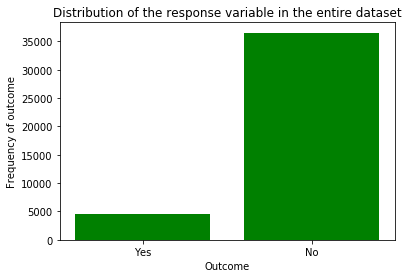

In [7]:
# Distribution of the response variable

x = ['Yes','No']
y = [len(bank_data[bank_data['y'] =='yes']), len(bank_data[bank_data['y'] =='no'])]



plt.bar(x, y, color='green')
plt.xlabel("Outcome")
plt.ylabel("Frequency of outcome")
plt.title("Distribution of the response variable in the entire dataset")
plt.show()


In [8]:
len(bank_data[bank_data['y'] =='yes']), len(bank_data[bank_data['y'] =='no'])

(4639, 36537)

# It can be seen that the dataset is highly imbalanced and different sampling techniques should be followed to prevent the model from being biased towards the majority class.

In [9]:
# Checking for any null or missing values in the dataset

bank_data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

# 2. Exploration and cleaning of categorical columns...

In [10]:
# Converting to categorical categorical type so thatthe dtype of the corresponding columns will be category.

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

#for column in categorical_columns:
 #   bank_data[column] = bank_data[column].astype('category')

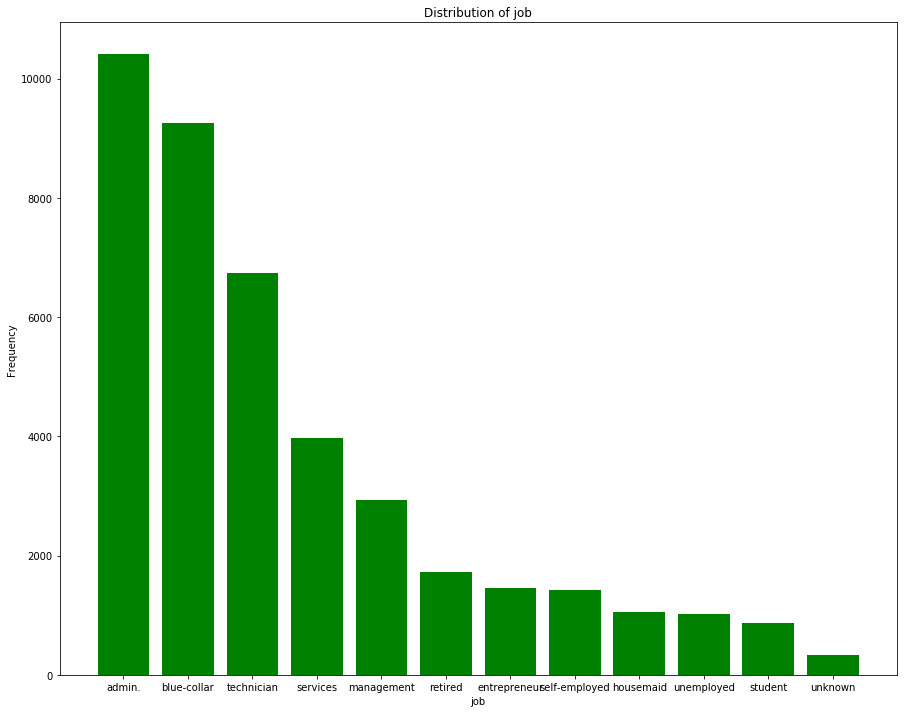

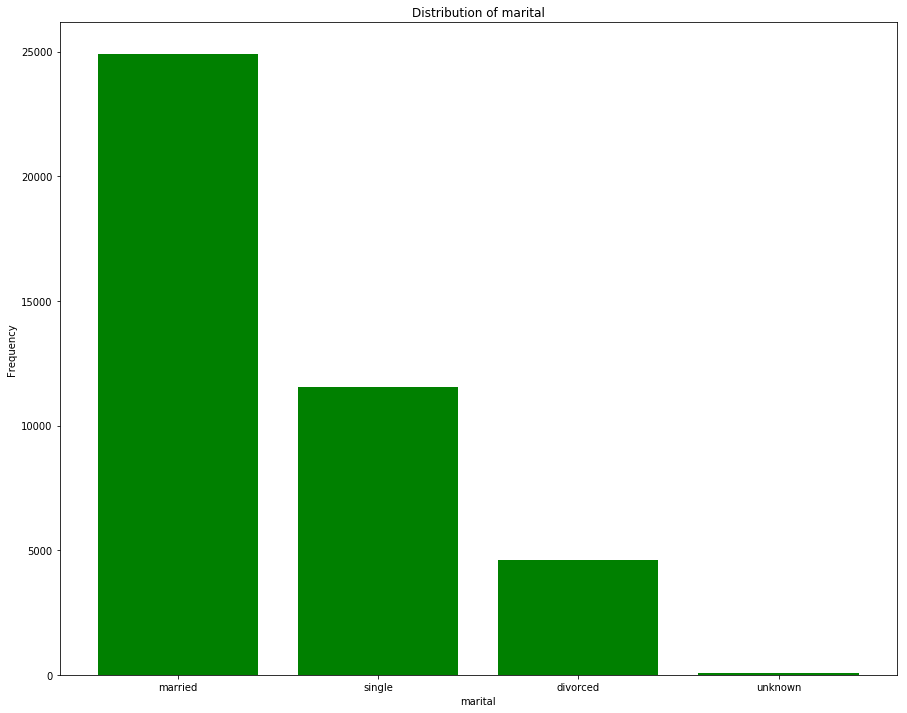

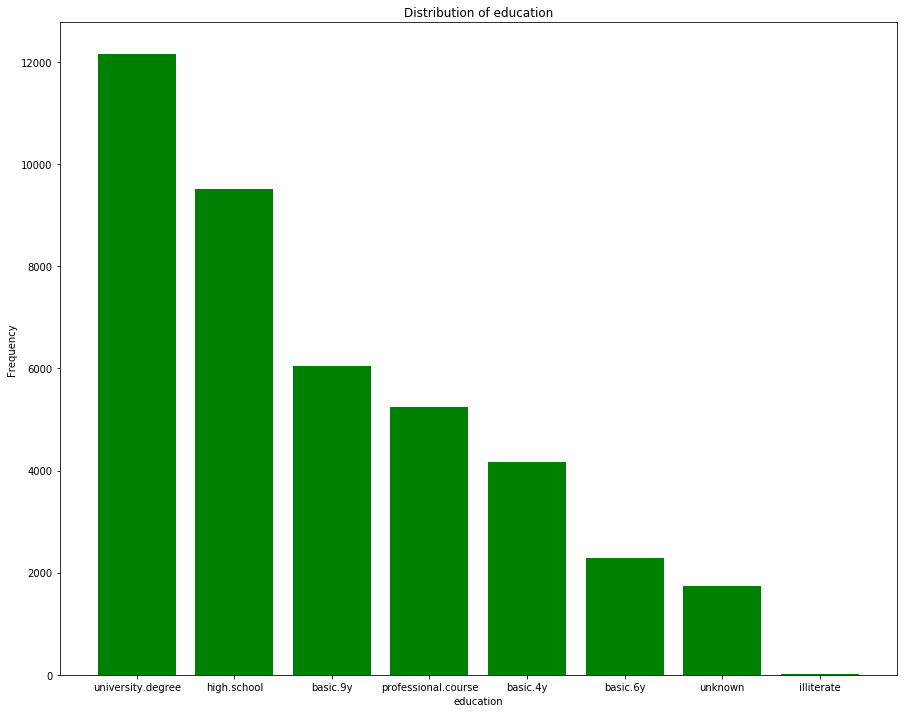

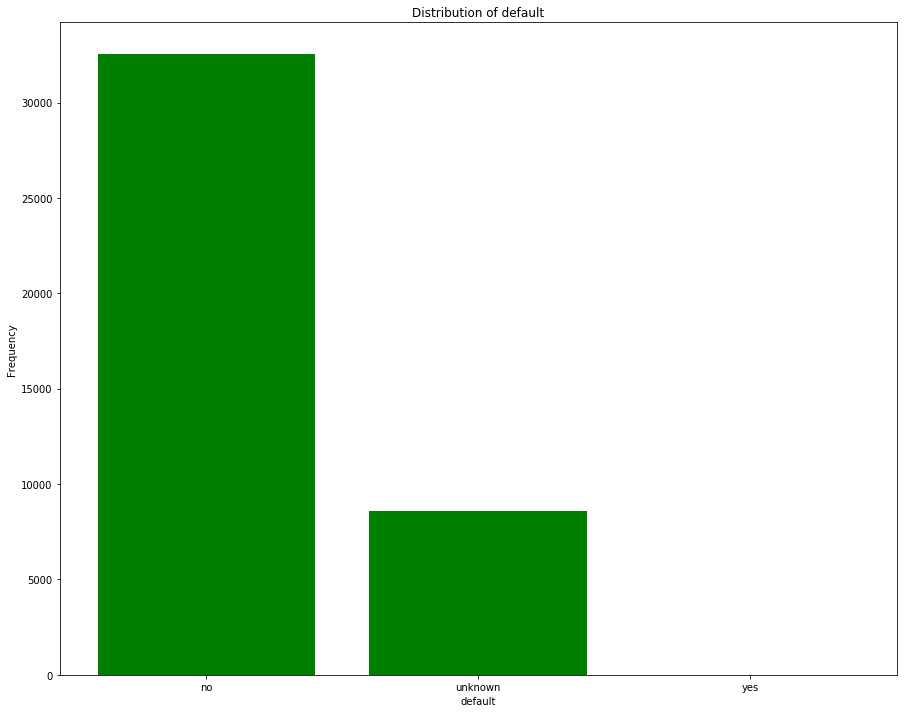

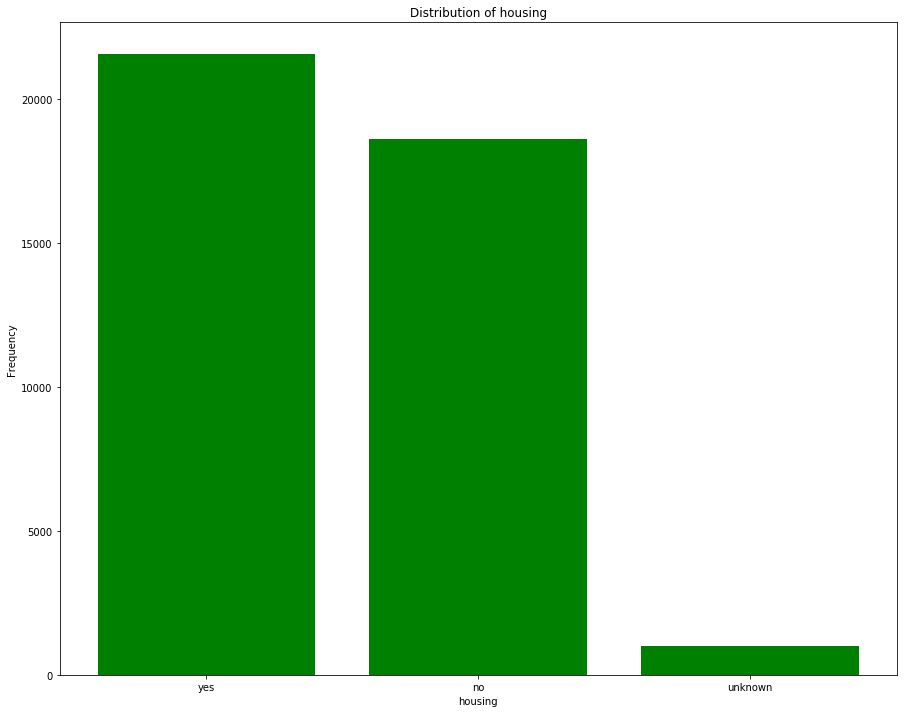

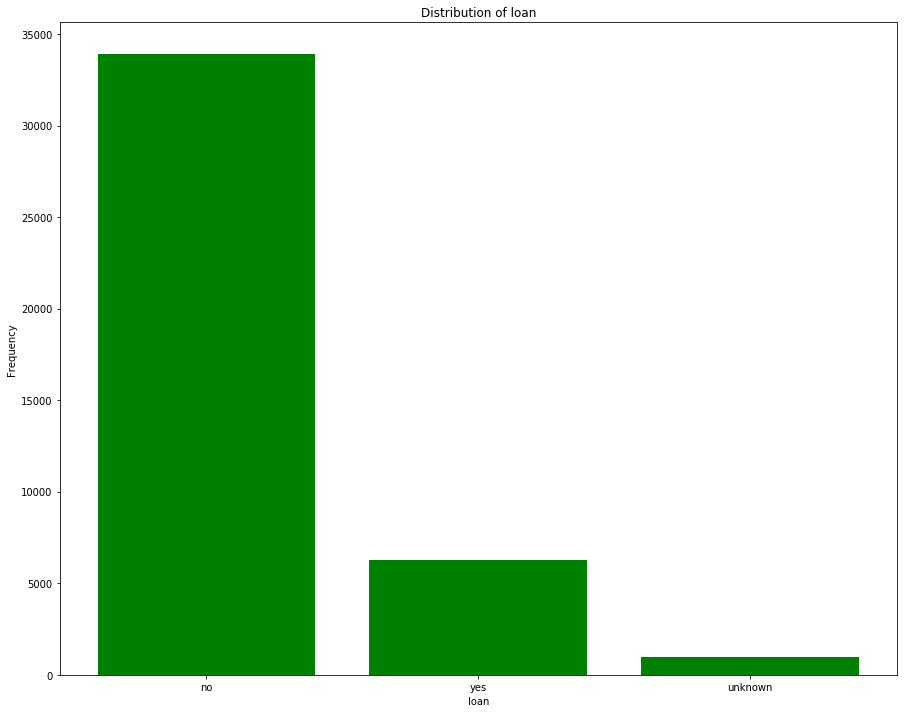

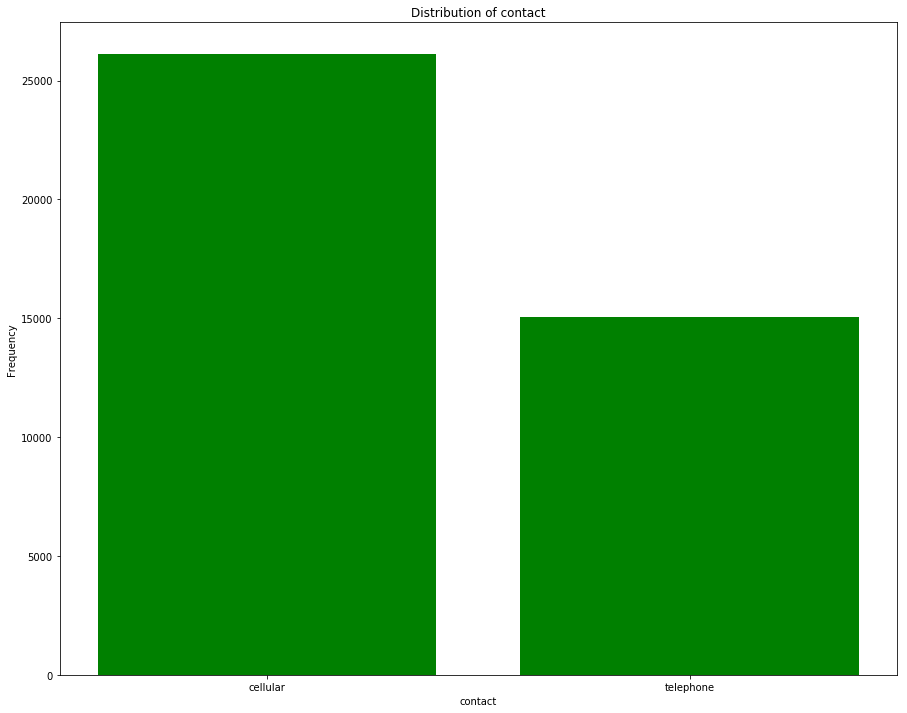

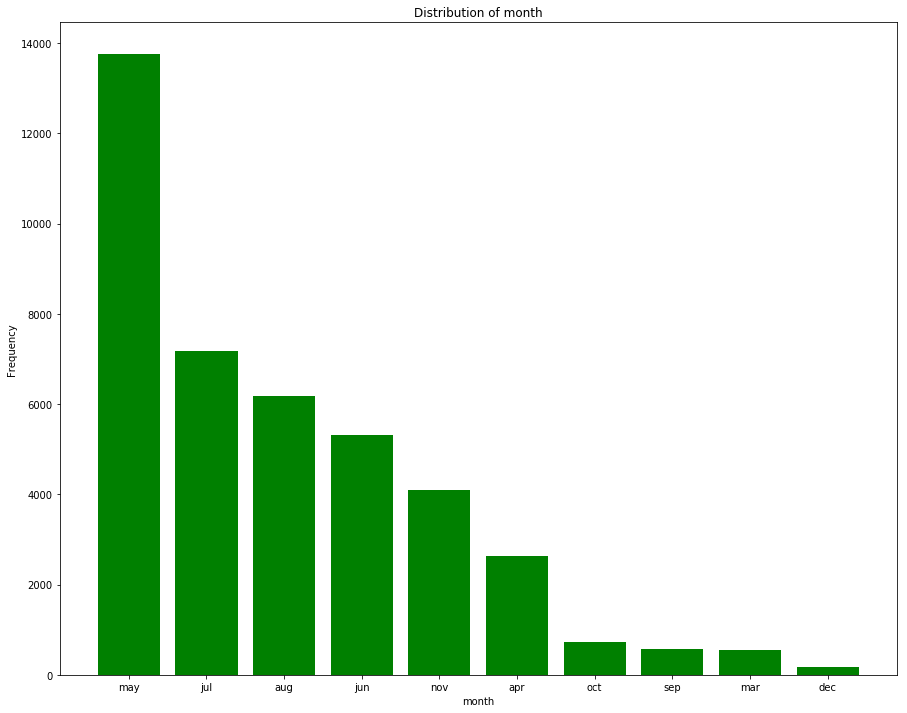

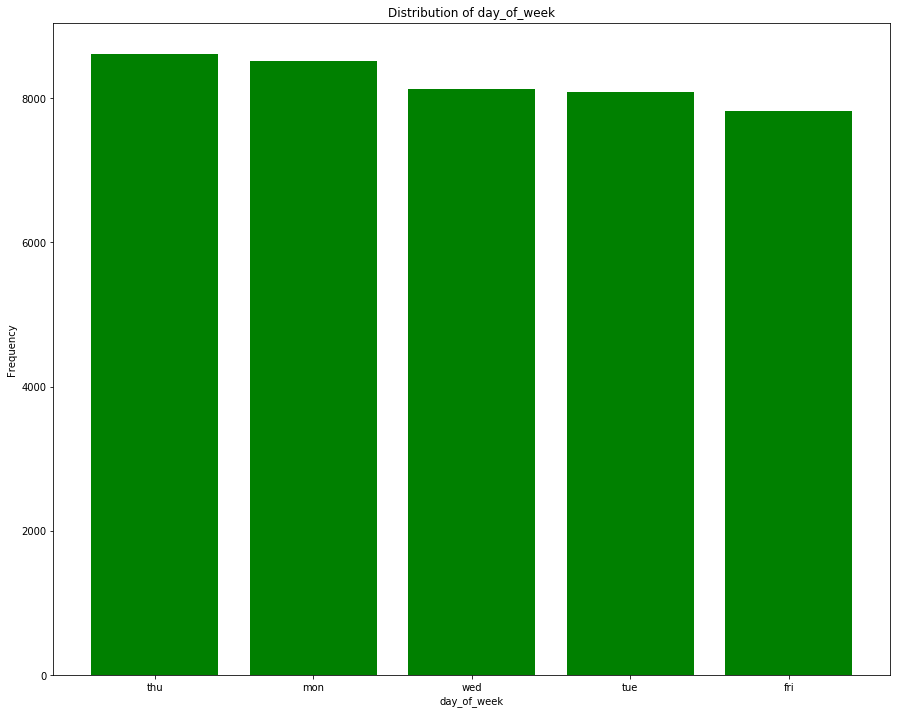

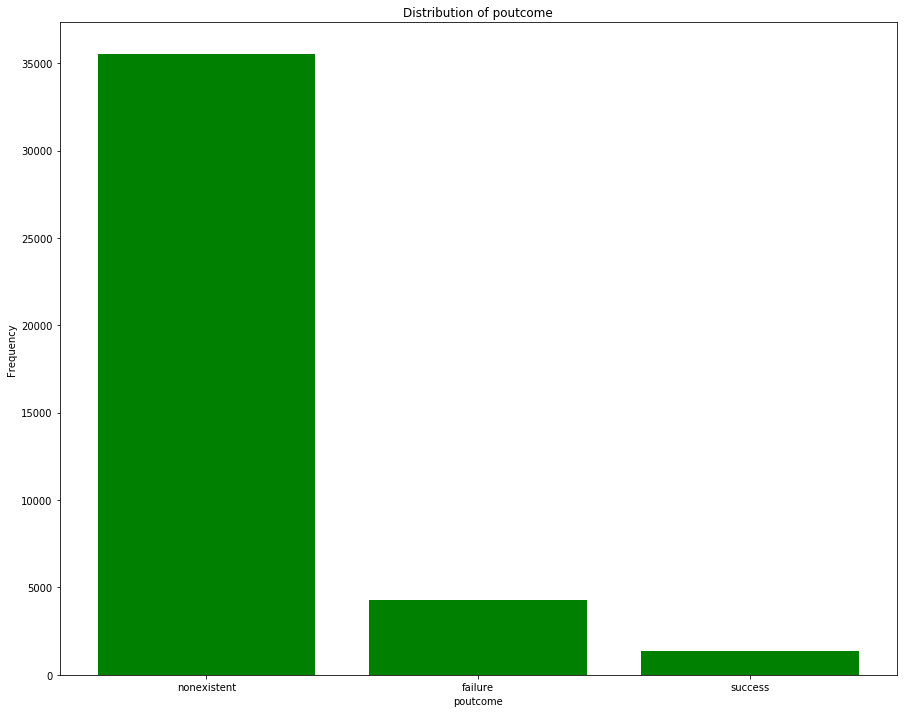

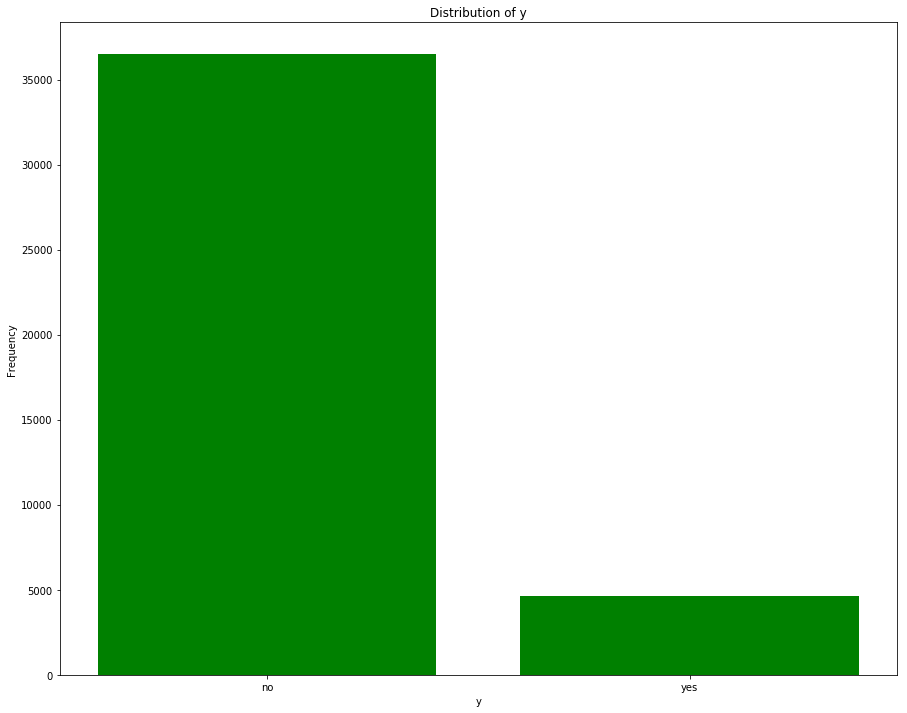

In [11]:
# Bar plots of categorical features

for feature in categorical_columns:
    plt.figure(figsize=(15,12))
    plt.bar(bank_data[feature].value_counts().index, bank_data[feature].value_counts().values, color='green')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Distribution of "+ feature)
    plt.show()

# As there are many categorical variables with sparse values and categories, they can be combined into the existing categories or dropped to simplify the modeling part.

# Proportion of each job category

In [12]:
bank_data['job'].value_counts()/len(bank_data)

admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: job, dtype: float64

# Almost 63% of the records fall within admin, blue-collar and technician category. Dropping the other categories will decrease the predictive power of the model. So similar categories can be combined.

# Proportion of marital status

In [13]:
bank_data['marital'].value_counts()/len(bank_data)

married     0.605231
single      0.280843
divorced    0.111983
unknown     0.001943
Name: marital, dtype: float64

# The single and divorced status can be combined into single and there is a less  proportion of unknown(less than 1%)  which can be removed.

# Proportion of eductaion

In [14]:
bank_data['education'].value_counts()/len(bank_data)

university.degree      0.295415
high.school            0.231008
basic.9y               0.146809
professional.course    0.127259
basic.4y               0.101418
basic.6y               0.055639
unknown                0.042015
illiterate             0.000437
Name: education, dtype: float64

# More than 50% of targetted individuals have a university degree or a high school diploma. There is a relatively small number of respondents with an unknown education level and illiterate ones, which can be dropped from the dataset and all the basic education levels can be combined into one and the professional course can be combined with university degree as they are almost the similar.

# Proportion of default

In [16]:
bank_data['default'].value_counts()/len(bank_data)

no         0.791165
unknown    0.208762
yes        0.000073
Name: default, dtype: float64

# There is a very small number of respondents who defaulted on a credit, so this variable doesn’t look very useful for prediction purposes and can be dropped from the dataset.

# Proportion of housing

In [17]:
bank_data['housing'].value_counts()/len(bank_data)

yes        0.523873
no         0.452084
unknown    0.024043
Name: housing, dtype: float64

# There is almost an equal proportion of yes and no levels and a very small proportion of unknown which can be removed from the dataset.

# Proportion of bank loan

In [18]:
bank_data['loan'].value_counts()/len(bank_data)

no         0.824218
yes        0.151739
unknown    0.024043
Name: loan, dtype: float64

# 82% of the respondents don’t have a personal loan. There is a small number of respondents with unknown loan status, which can be dropped from the dataset.

# The contact column can be removed becasue every respondent has been contacted and having this will only increase the complexity of the model.

# Proportion of months

In [19]:
bank_data['month'].value_counts()/len(bank_data)

may    0.334345
jul    0.174106
aug    0.149990
jun    0.129153
nov    0.099573
apr    0.063896
oct    0.017413
sep    0.013843
mar    0.013260
dec    0.004420
Name: month, dtype: float64

# It can be seen that many respondents have been contacted during the Summer months indicating that there is a greater possibilty of subscription to a term deposit when contacted during a particular month/season. We can retain the months variable to determine if the month of contact is a useful predictor for subscription for a term deposit. Also, to reduce the complexity of the model we can group months into three seasons.

# may,jun, jul,aug - summer
# sep, oct,nov,dec- winter
# jan,feb,mar,apr- spring

# Proportion of days of week

In [20]:
bank_data['day_of_week'].value_counts()/len(bank_data)

thu    0.209297
mon    0.206722
wed    0.197542
tue    0.196377
fri    0.190062
Name: day_of_week, dtype: float64

# There is no skewness in the days of the week as they are evenly distributed. We can retain this variable to finally check if the day of the week contacted can influence the response variable.

# Proportion of poutcome

In [21]:
bank_data['poutcome'].value_counts()/len(bank_data)

nonexistent    0.863391
failure        0.103264
success        0.033345
Name: poutcome, dtype: float64

# It can be seen that almost 87% of the resposdents have never been contacted before and hence we can divide this group into new and exisiting customers. There are more chances that the exisiting customers who have not subscribed before can subscribe as they are already aware of the plan and they have already been contacted before.

In [22]:
bank_data.shape

(41176, 21)

In [23]:
# Combining the similar job  categories.

bank_data['job'] = bank_data['job'].replace(['management', 'admin.','technician'], 'white-collar')
bank_data['job'] = bank_data['job'].replace(['services','housemaid'], 'pink-collar')
bank_data['job'] = bank_data['job'].replace(['retired', 'student', 'unemployed', 'unknown','entrepreneur', 'self-employed'], 'unemployed/self-employed')


# Combining marital status categories and removing unknown rows.

bank_data['marital'] = bank_data['marital'].replace(['single', 'divorced'], 'single')
#bank_data = bank_data[bank_data.marital != 'unknown']
bank_data['marital'] = bank_data['marital'].replace(['unknown'], np.nan)



# Combining similar education categories and removing unknown and illiterate rows.

bank_data['education'] = bank_data['education'].replace(['basic.9y', 'basic.4y','basic.6y'], 'basic')
bank_data['education'] = bank_data['education'].replace(['professional.course'], 'university.degree')
#bank_data = bank_data[bank_data.education != 'unknown']
#bank_data = bank_data[bank_data.education != 'illiterate']
bank_data['education'] = bank_data['education'].replace(['unknown','illiterate'], np.nan)



# Dropping the default column

bank_data = bank_data.drop('default', axis =1)

# Removing the unknown rows in the housing column.

#bank_data = bank_data[bank_data.housing != 'unknown']
bank_data['housing'] = bank_data['housing'].replace(['unknown'], np.nan)

# removing the unknown rows from the loan column.

#bank_data = bank_data[bank_data.loan != 'unknown']
bank_data['loan'] = bank_data['loan'].replace(['unknown'], np.nan)

# Dropping the contact columns

bank_data = bank_data.drop('contact', axis =1)

# Combining months into seasons

bank_data['month'] = bank_data['month'].replace(['may', 'jun','jul','aug'], 'summer')
bank_data['month'] = bank_data['month'].replace(['sep', 'oct','nov','dec'], 'winter')
bank_data['month'] = bank_data['month'].replace(['jan', 'feb','mar','apr'], 'spring')





In [24]:
bank_data = bank_data.dropna()

In [25]:
len(bank_data)

38408

In [26]:
len(bank_data[bank_data['poutcome']== 'nonexistent'] ), len(bank_data[bank_data['pdays']== 999] )

(33208, 37030)

# It can be seen that there is a significant difference in the count of nonexistent category in poutcome(new customer)column and the pdays column having the value of 999(customers who have never been contacted before) which is logically incorrect.

In [27]:
len(bank_data[bank_data['poutcome']== 'nonexistent'] ), len(bank_data[bank_data['previous'] == 0])

(33208, 33208)

# But the count of new custoners matches with the count of previous column having value 0 (zero contacts performed before the current campaign).

In [28]:
wrong_data =  bank_data[(bank_data['poutcome'] != 'nonexistent') &(bank_data['pdays'] ==999) ]
len(wrong_data)

3822

# There are 3822 records that have poutcome != nonexistent and pdays = 999 which is logically incorrect. They are ~ 10% of the data and can be removed from the dataset and still we would have sufficient data to train.

In [29]:
# Removing the wrong records

bank_data = bank_data.loc[~bank_data.set_index(list(bank_data.columns)).index.isin(wrong_data.set_index(list(wrong_data.columns)).index)]

In [30]:
# length of dataset after treating categorical values

len(bank_data) 

34586

# Checking if the categorical variables are independent of each other, using a chi-square test with a 95% level of confidence using the following pairs.

# 'job' - 'marital'
# 'job' - 'education'
# 'job' - 'housing'
# 'job' - 'loan'
# 'marital' - 'education'
# 'marital' - 'housing'
# 'marital' - 'loan'
# 'education' - 'housing'
# 'education' - 'loan'
# 'housing' - 'loan'


# it doesn't make much sense to do a chi-square test for days of the week or months, and the dependence/independence of the outcome of the previous campaign should be checked by a more comprehensive method, like logistic regression

# The Chi-Square test of independence is used to determine if there is a significant relationship between two nominal (categorical) variables.  The frequency of each category for one nominal variable is compared across the categories of the second nominal variable.  

# Hypothesis:
# Null hypothesis: Assumes that there is no association between the two variables.
# Alternative hypothesis: Assumes that there is an association between the two variables.

In [31]:
def chisquare(column1, column2):
    
    #Creating the contingency table for comparing 'each pairs of categorical columns
    contingency_table = pd.crosstab(index=bank_data[column1], columns=bank_data[column2])
    chi2, p, dof, ex =stats.chi2_contingency(contingency_table)
    return contingency_table, chi2, p, dof
    

marital                   married  single
job                                      
blue-collar                  5648    2069
pink-collar                  2609    1613
unemployed/self-employed     3388    2065
white-collar                 9483    7711
Chisquare value is  733.5739985502103
P-value is  1.1007356358252034e-158


Text(0.5, 1.0, 'Comparing job - marital')

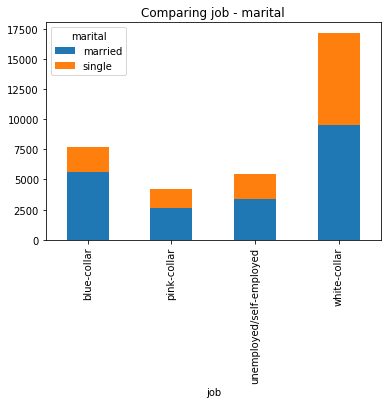

In [32]:
# Comparing 'job' - 'marital'

contin_table1, chisq1, p_val1, degoff = chisquare('job','marital')
print(contin_table1)
print('Chisquare value is  ' + str(chisq1))
print('P-value is  ' + str(p_val1))
contin_table1.plot.bar(stacked=True)
plt.title('Comparing job - marital')

# It can be seen that job and marital status are dependent.

education                 basic  high.school  university.degree
job                                                            
blue-collar                6493          749                475
pink-collar                1235         2463                524
unemployed/self-employed   1869         1095               2489
white-collar               1424         3923              11847
Chisquare value is  18286.801088514778
P-value is  0.0


Text(0.5, 1.0, 'Comparing job - education')

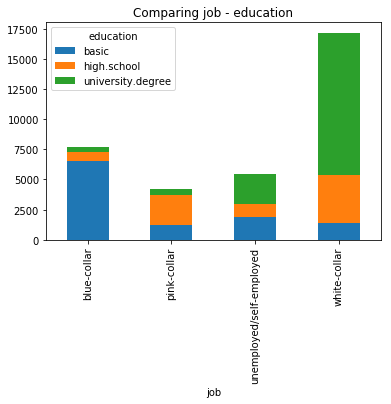

In [33]:
# Comparing 'job' - 'education'

contin_table2, chisq2, p_val2, degoff2 = chisquare('job','education')
print(contin_table2)
print('Chisquare value is  ' + str(chisq2))
print('P-value is  ' + str(p_val2))
contin_table2.plot.bar(stacked=True)
plt.title('Comparing job - education')

# It can be seen that job and education are dependent.

housing                     no   yes
job                                 
blue-collar               3662  4055
pink-collar               2014  2208
unemployed/self-employed  2497  2956
white-collar              7941  9253
Chisquare value is  6.946099538254138
P-value is  0.0736357514726


Text(0.5, 1.0, 'Comparing job - hosuing loan')

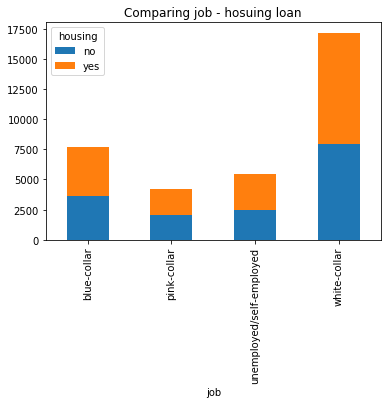

In [34]:
# Comparing 'job' - 'housing'

contin_table3, chisq3, p_val3, degoff3 = chisquare('job','housing')
print(contin_table3)
print('Chisquare value is  ' + str(chisq3))
print('P-value is  ' + str(p_val3))
contin_table3.plot.bar(stacked=True)
plt.title('Comparing job - hosuing loan')

# It can be seen that job and housing loan are independent.

loan                         no   yes
job                                  
blue-collar                6551  1166
pink-collar                3571   651
unemployed/self-employed   4652   801
white-collar              14418  2776
Chisquare value is  8.833579201344154
P-value is  0.0315873591798059


Text(0.5, 1.0, 'Comparing job - loan')

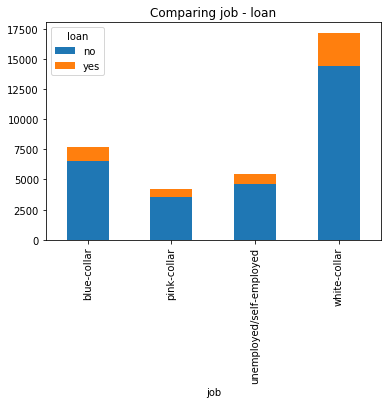

In [35]:
# Comparing 'job' - 'loan'

contin_table4, chisq4, p_val4, degoff4 = chisquare('job','loan')
print(contin_table4)
print('Chisquare value is  ' + str(chisq4))
print('P-value is  ' + str(p_val4))
contin_table4.plot.bar(stacked=True)
plt.title('Comparing job - loan')

# It can be seen that job and personal loan are dependent.

education  basic  high.school  university.degree
marital                                         
married     8115         4526               8487
single      2906         3704               6848
Chisquare value is  1071.000546087938
P-value is  2.7238698922182203e-233


Text(0.5, 1.0, 'Comparing education - marital')

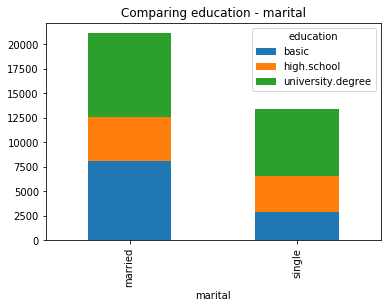

In [36]:
# Comparing 'marital' - 'education'

contin_table5, chisq5, p_val5, degoff5 = chisquare('marital','education')
print(contin_table5)
print('Chisquare value is  ' + str(chisq5))
print('P-value is  ' + str(p_val5))
contin_table5.plot.bar(stacked=True)
plt.title('Comparing education - marital')

# It can be seen that education and marital status are dependent.

housing    no    yes
marital             
married  9926  11202
single   6188   7270
Chisquare value is  3.26527117663477
P-value is  0.07076132243739053


Text(0.5, 1.0, 'Comparing housing - marital')

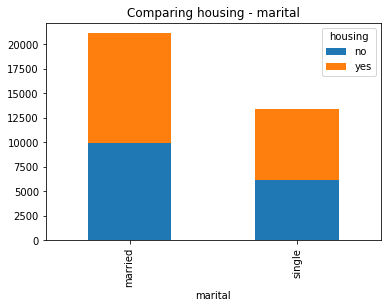

In [37]:
# Comparing 'marital' - 'housing'

contin_table6, chisq6, p_val6, degoff6 = chisquare('marital','housing')
print(contin_table6)
print('Chisquare value is  ' + str(chisq6))
print('P-value is  ' + str(p_val6))
contin_table6.plot.bar(stacked=True)
plt.title('Comparing housing - marital')

# It can be seen that housing loan and marital status are independent.

loan        no   yes
marital             
married  17851  3277
single   11341  2117
Chisquare value is  0.28632559638453814
P-value is  0.5925848538041338


Text(0.5, 1.0, 'loan - marital')

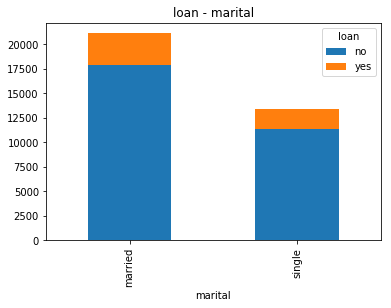

In [38]:
# Comparing 'marital' - 'loan'

contin_table7, chisq7, p_val7, degoff7 = chisquare('marital','loan')
print(contin_table7)
print('Chisquare value is  ' + str(chisq7))
print('P-value is  ' + str(p_val7))
contin_table7.plot.bar(stacked=True)
plt.title('loan - marital')

# It can be seen that personal loan and marital status are independant.

housing              no   yes
education                    
basic              5242  5779
high.school        3913  4317
university.degree  6959  8376
Chisquare value is  16.244373954099423
P-value is  0.00029687868309140076


Text(0.5, 1.0, 'Comparing education - housing')

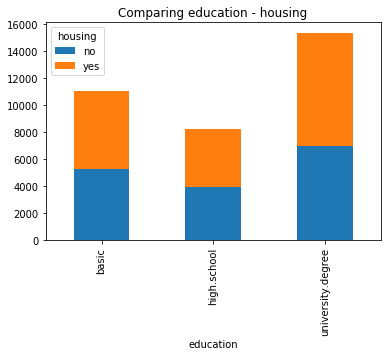

In [39]:
# Comparing 'education' - 'housing'

contin_table8, chisq8, p_val8, degoff8 = chisquare('education','housing')
print(contin_table8)
print('Chisquare value is  ' + str(chisq8))
print('P-value is  ' + str(p_val8))
contin_table8.plot.bar(stacked=True)
plt.title('Comparing education - housing')

# It can be seen that education is dependent of housing loan.

loan                  no   yes
education                     
basic               9366  1655
high.school         6945  1285
university.degree  12881  2454
Chisquare value is  4.736791032669258
P-value is  0.09363083496766601


Text(0.5, 1.0, 'Comparing education - loan')

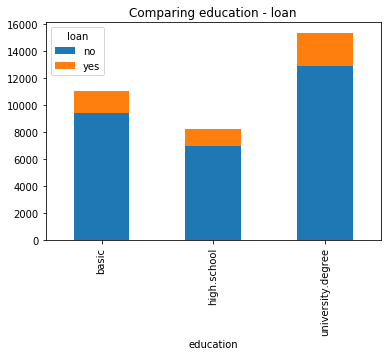

In [40]:
# Comparing 'education' - 'loan'

contin_table9, chisq9, p_val9, degoff9 = chisquare('education','loan')
print(contin_table9)
print('Chisquare value is  ' + str(chisq9))
print('P-value is  ' + str(p_val9))
contin_table9.plot.bar(stacked=True)
plt.title('Comparing education - loan')

# It can be seen that education is independent of personal loan.

loan        no   yes
housing             
no       13893  2221
yes      15299  3173
Chisquare value is  75.06824606192455
P-value is  4.5472116329016205e-18


Text(0.5, 1.0, 'Comparing housing - loan')

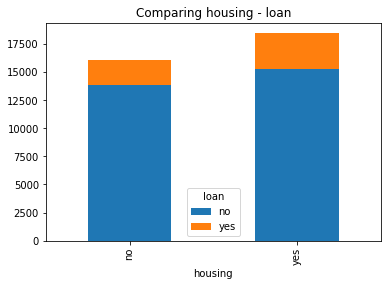

In [41]:
# Comparing 'housing' - 'loan'

contin_table10, chisq10, p_val10, degoff10 = chisquare('housing','loan')
print(contin_table10)
print('Chisquare value is  ' + str(chisq10))
print('P-value is  ' + str(p_val10))
contin_table10.plot.bar(stacked=True)
plt.title('Comparing housing - loan')

# It can be seen that housing loan is dependent on personal loan.



# Job level depends on the education level, marital status, personal loan and is independent of  housing loan.
# Marital status depends on the education level and job level and independent of personal and housing loan.
# Education level depends on the  job level, housing loan and marital status and is independent of personal loan.
# Housing loan depends on the personal loan and education level and is independent of the job level and marital status.
# Personal loan depends on the housing loan and job level and is independent of  marital status, and education level.

# Proportion of the categories of each column with respect to the outcome of the campaign.



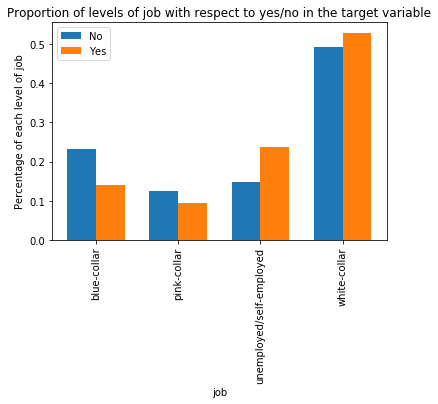

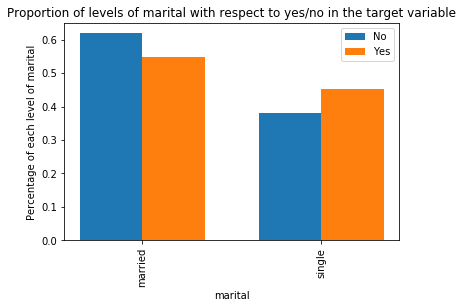

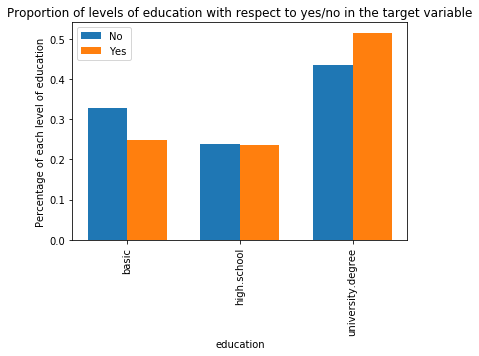

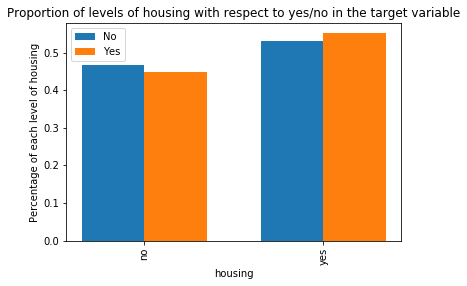

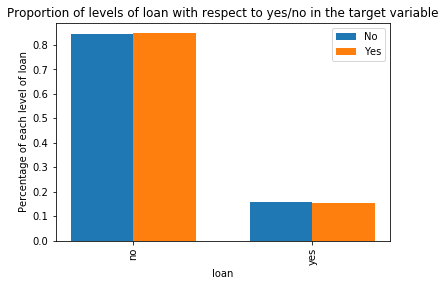

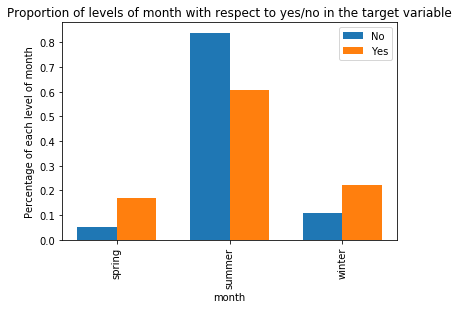

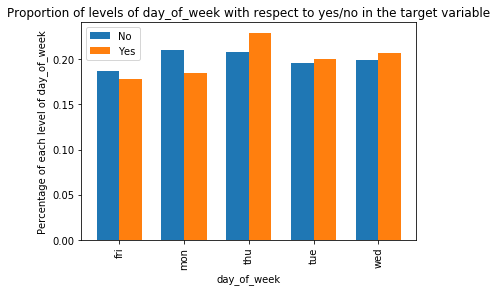

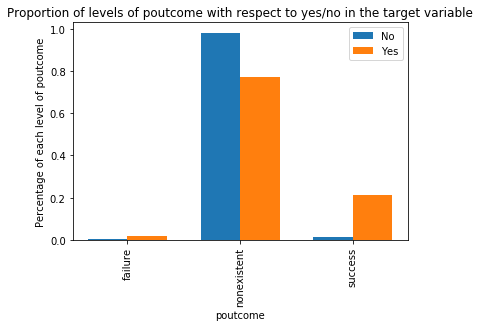

In [42]:

categorical_columns_1 = ['job','marital', 'education', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']

for column in categorical_columns_1:
    s1 = (bank_data[bank_data['y'] == 'no'][column].value_counts()/ len(bank_data[bank_data['y'] == 'no']))
    s2 = (bank_data[bank_data['y'] == 'yes'][column].value_counts()/ len(bank_data[bank_data['y'] == 'yes']))
    s1 =s1.sort_index()
    s2 =s2.sort_index()
    N = len(s1.index)

    ind = np.arange(N) 
    width = 0.35       
    plt.bar(ind, s1.values, width, label='No')
    plt.bar(ind + width, s2.values, width, label='Yes')

    plt.xlabel(column)
    plt.ylabel('Percentage of each level of ' + column)
    plt.title('Proportion of levels of '+ column + ' with respect to yes/no in the target variable')

    plt.xticks(ind + width / 2, s1.index, rotation = 'vertical')
    plt.legend(loc='best')
    plt.show()

# From the job category it can be seen that people with white-collar job and the unemployed/self-employed categiry are most likely to respond positively to the campaign than the other categories. The job category column can have an impact on the response of the campaign.

# From the marital column, It can be observed, that the people in the single category are more likely to respond positively to the campaign results. So, the marital status can have an impact on the prediction of the results.

# From the eductaion column, it can be observed that people with university degree are more likely to respond positively to the campaign than the other categories. So, the education column can have an impact on the outcome of the campaign.

# From the housing column, it can be observed there is not much of a significant difference in the outcome of the campaign for people with or without a housing loan. So, the housing loan column might have a very small impact on the predictions.

# From the loan column, it can be observed there is not much of a significant difference in the outcome of the campaign for people with or without a personal loan. So, the loan column might not have an impact on the predictions.

# From the month column, it can be seen that  people contacted during the spring and winter seasons are more likely to respond positively. So, the month column might be an impact on the predictions.

# From the week column, it can be observed there is not much of a significant difference in the outcome of the campaign for people contacted during different days of the week. So, the week column might not have an impact on the predictions.

# From the poutcome column, it can be seen that people who have been contacted during the previous campaign are more likely to respond positively. So, the poutcoem column can have an impact on the future predictions.

white-collar                17194
blue-collar                  7717
unemployed/self-employed     5453
pink-collar                  4222
Name: job, dtype: int64


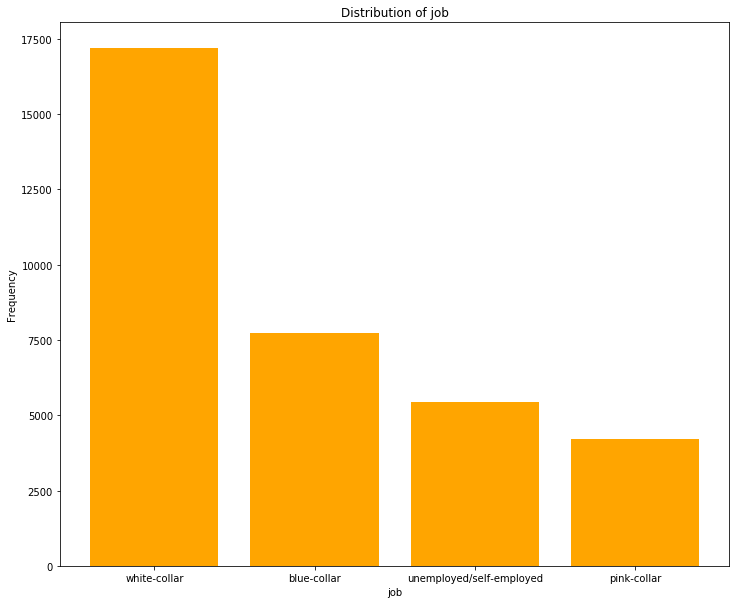

married    21128
single     13458
Name: marital, dtype: int64


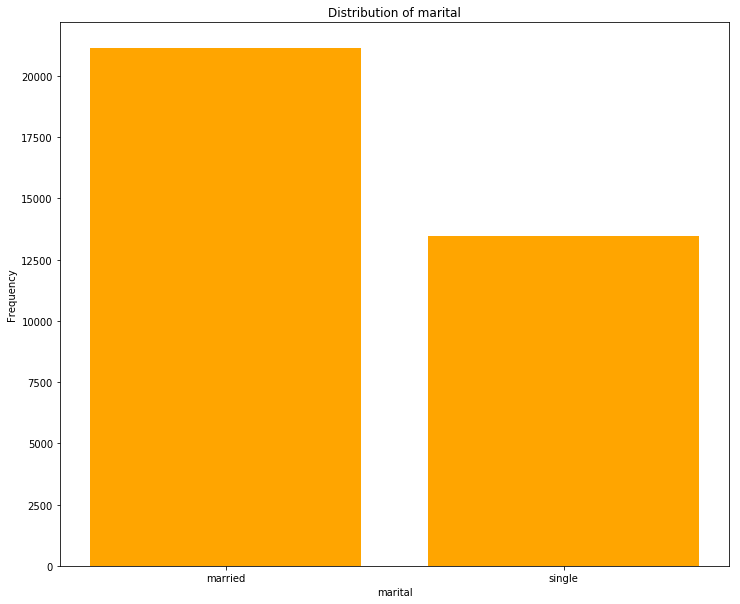

university.degree    15335
basic                11021
high.school           8230
Name: education, dtype: int64


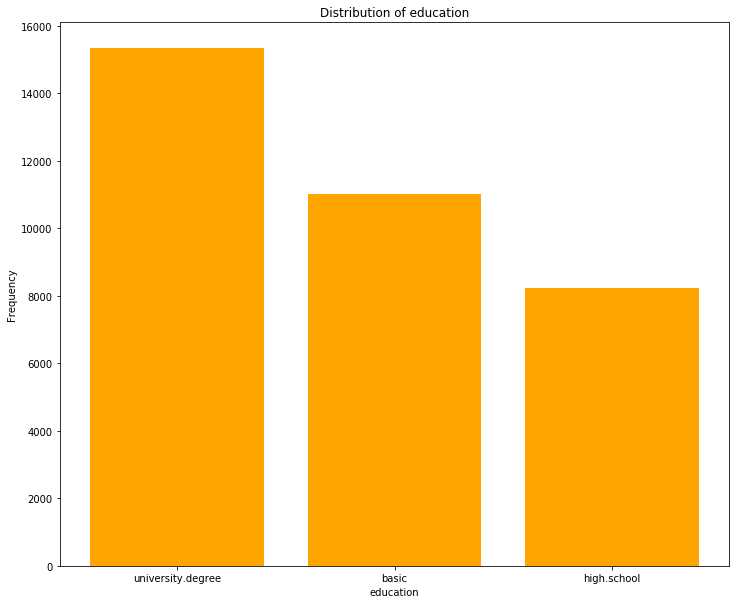

yes    18472
no     16114
Name: housing, dtype: int64


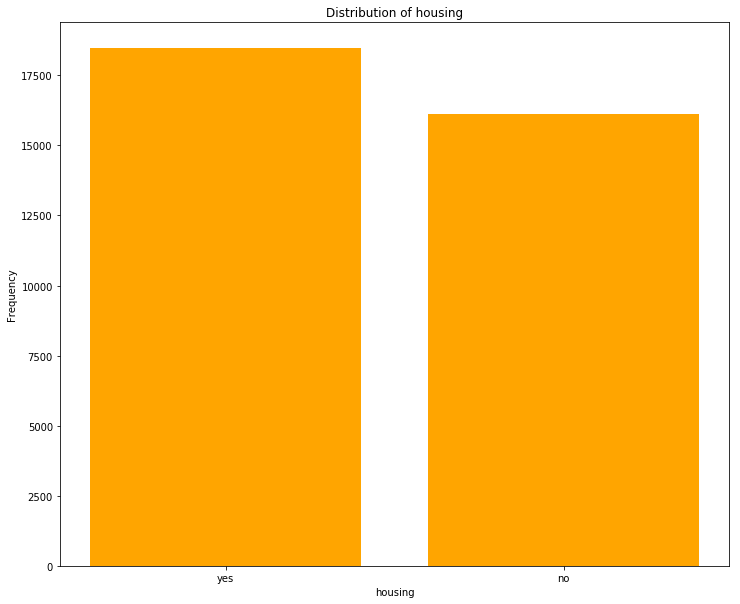

no     29192
yes     5394
Name: loan, dtype: int64


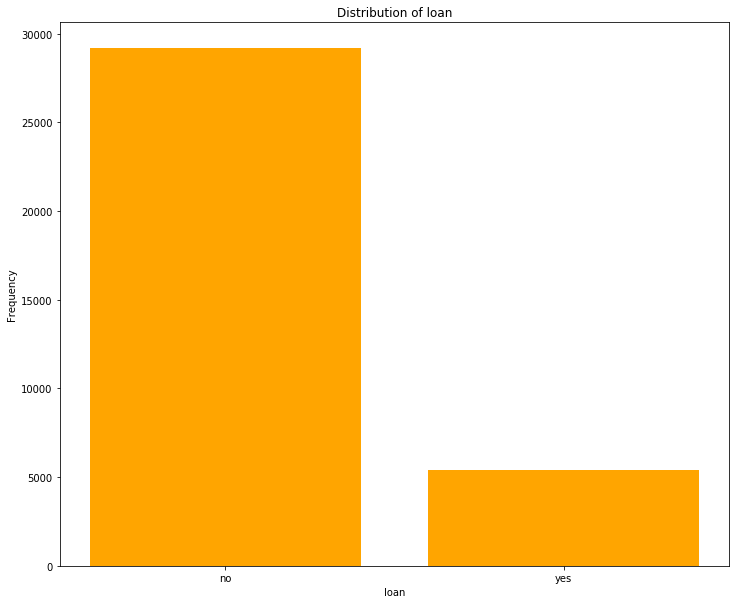

summer    28135
winter     4187
spring     2264
Name: month, dtype: int64


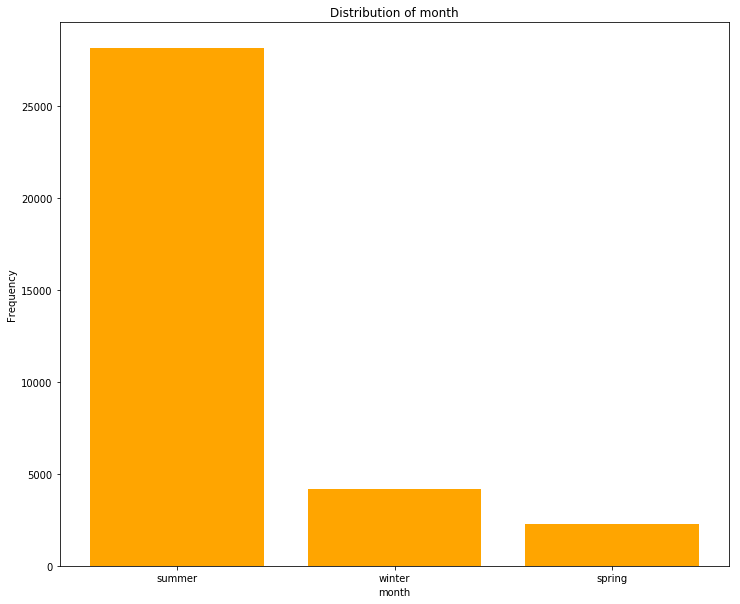

thu    7277
mon    7186
wed    6905
tue    6798
fri    6420
Name: day_of_week, dtype: int64


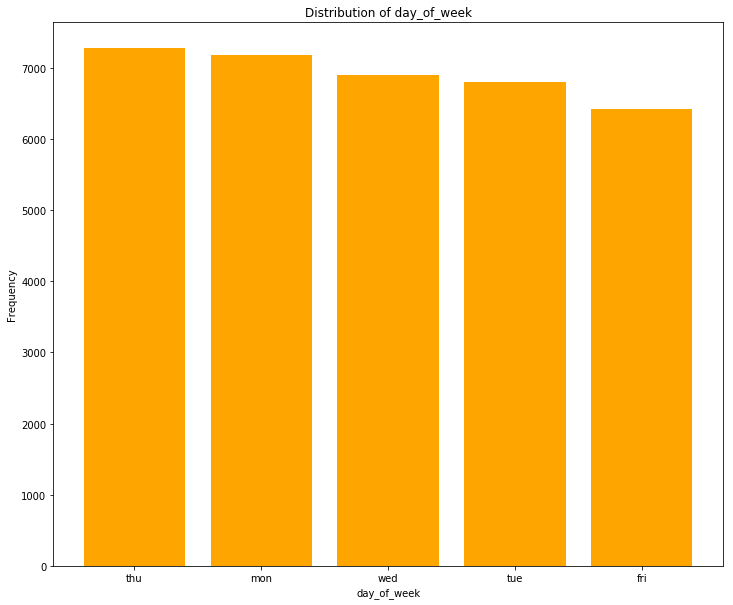

nonexistent    33208
success         1255
failure          123
Name: poutcome, dtype: int64


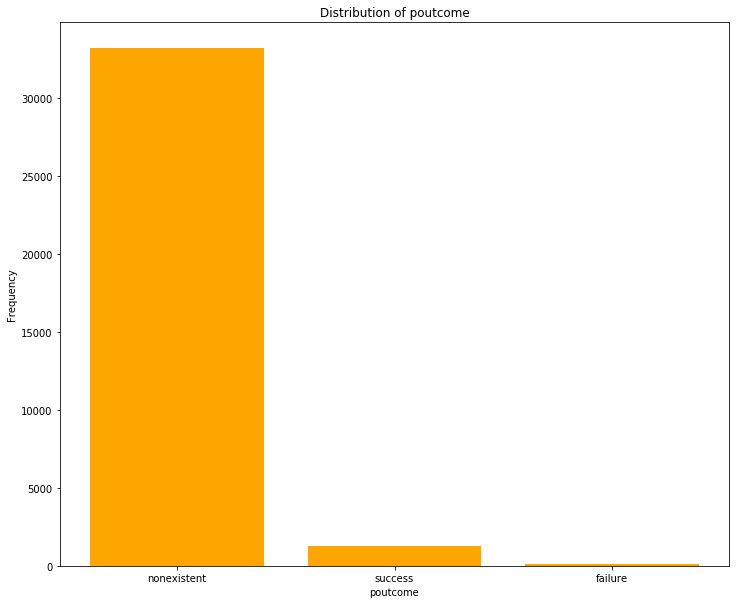

In [46]:
# Converting to categorical categorical type so that the dtype of the corresponding columns will be category.

categorical_columns_1 = ['job','marital', 'education', 'housing', 'loan', 'month', 'day_of_week', 'poutcome']


#Bar plots of cleaned categorical features

for feature in categorical_columns_1:
    print(bank_data[feature].value_counts())
    plt.figure(figsize=(12,10))
    plt.bar(bank_data[feature].value_counts().index, bank_data[feature].value_counts().values, color='orange')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Distribution of "+ feature)
    plt.show()

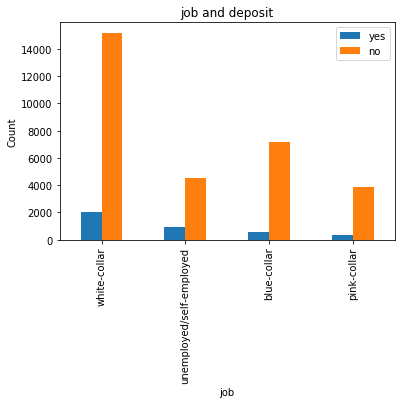

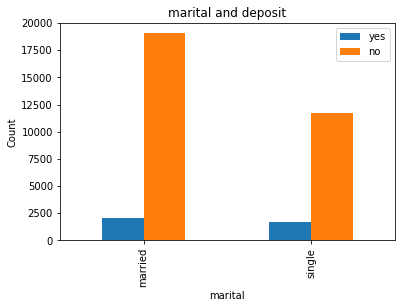

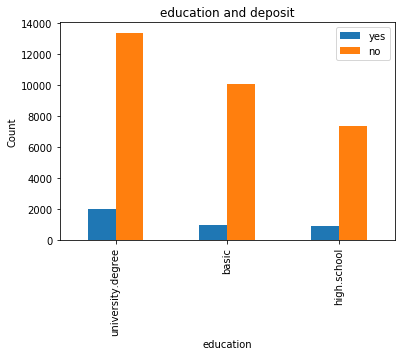

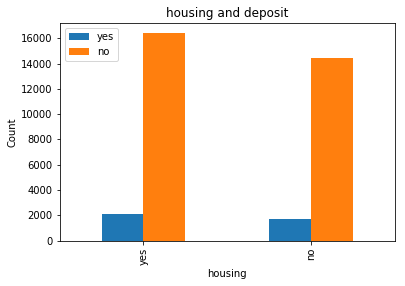

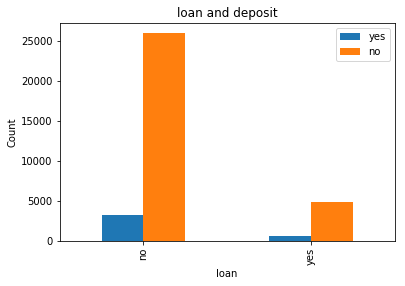

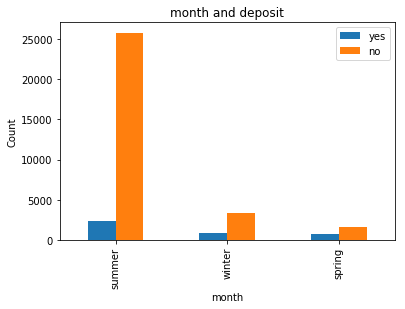

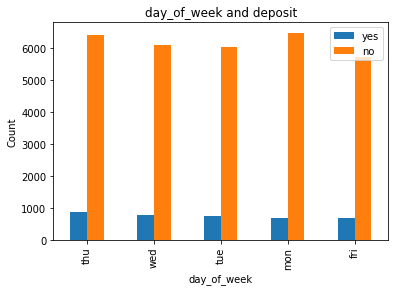

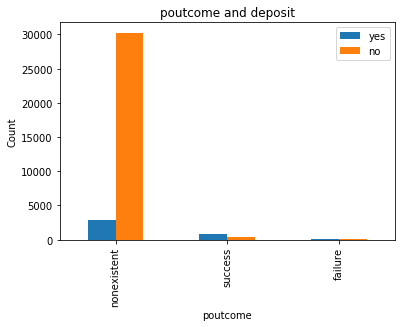

In [52]:
# Distribution of categorical values with repesct to the response variable

#type of contact and deposit
for column in categorical_columns_1:

    temp_df = pd.DataFrame()

    temp_df['yes'] = bank_data[bank_data['y'] == 'yes'][column].value_counts()
    temp_df['no'] = bank_data[bank_data['y'] == 'no'][column].value_counts()

    temp_df.plot.bar(title = column + ' and deposit')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# It can be seen that in every categorical feature and for each category, people are most likely not to subscribe.

# 4. Exploration  and cleaning of numerical columns...

In [53]:
# Corelation matrix to check for multicollinearity

bank_data.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.002063,0.006523,-0.040458,0.037350,-0.001697,-0.003366,0.122883,0.008415,-0.017253
duration,-0.002063,1.000000,-0.074762,-0.045052,0.038069,-0.032561,0.000763,-0.014498,-0.036231,-0.046650
campaign,0.006523,-0.074762,1.000000,0.057033,-0.049423,0.140359,0.119921,-0.019865,0.124991,0.135658
pdays,-0.040458,-0.045052,0.057033,1.000000,-0.868563,0.321747,0.109011,-0.086368,0.350169,0.428331
previous,0.037350,0.038069,-0.049423,-0.868563,1.000000,-0.269432,-0.045580,0.064653,-0.309945,-0.400267
emp.var.rate,-0.001697,-0.032561,0.140359,0.321747,-0.269432,1.000000,0.765213,0.203887,0.973279,0.911406
cons.price.idx,-0.003366,0.000763,0.119921,0.109011,-0.045580,0.765213,1.000000,0.042817,0.685099,0.527916
cons.conf.idx,0.122883,-0.014498,-0.019865,-0.086368,0.064653,0.203887,0.042817,1.000000,0.282476,0.105002
euribor3m,0.008415,-0.036231,0.124991,0.350169,-0.309945,0.973279,0.685099,0.282476,1.000000,0.945446
nr.employed,-0.017253,-0.046650,0.135658,0.428331,-0.400267,0.911406,0.527916,0.105002,0.945446,1.000000


# From the correlation matrix it can be seen that the economic indicators have a high correlation with each other. There is also a high negative correlation between pdays and previous since the largest value of “pdays” (999) corresponds to the smallest value of “previous” (0).

# The strongly correlated varioables should be combined or dropped, else there might be a problem of multicollinearity when training the model which might cause overfitting that does not significantly improve the validation accuracy.

In [54]:
numeric_columns = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

In [55]:
len(numeric_columns)

10

Text(0.5, 1.05, 'Correlation heatmap of numeric columns')

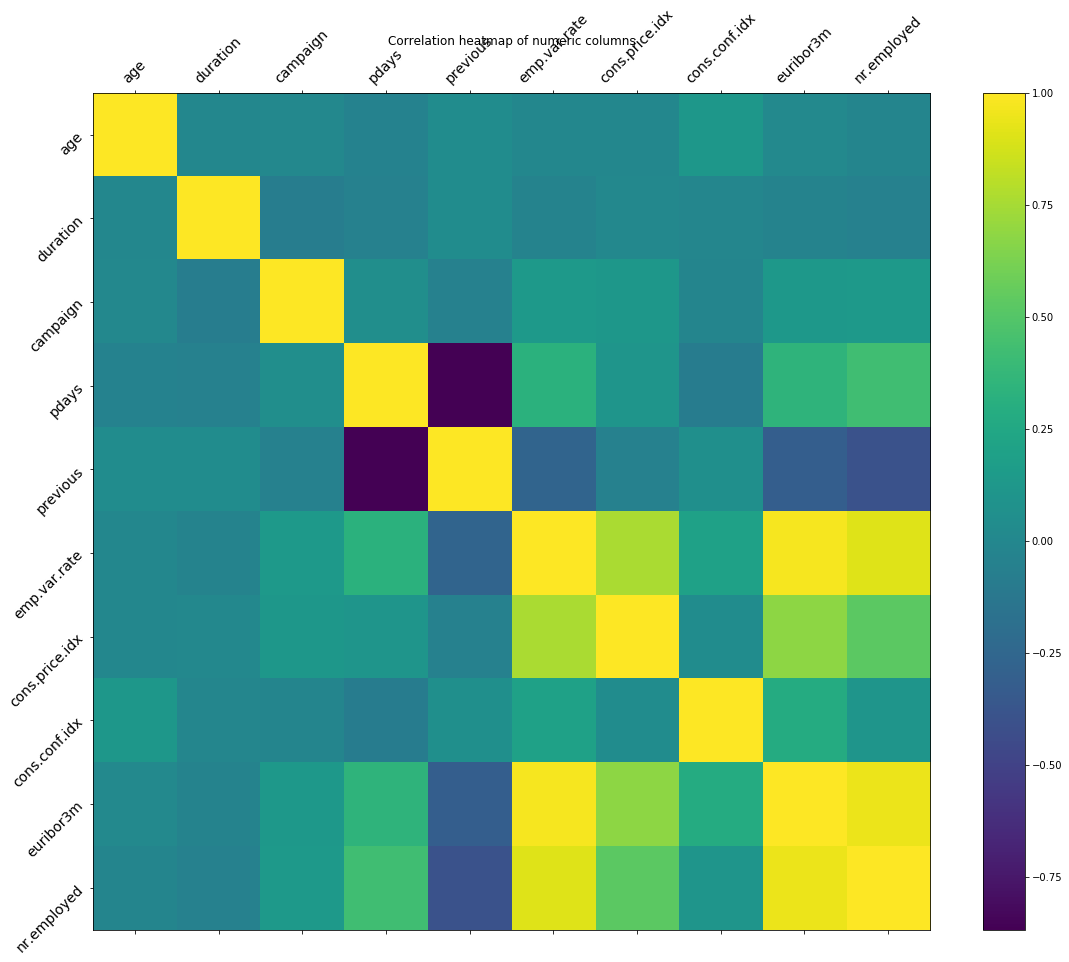

In [56]:
f = plt.figure(figsize=(19, 15))
plt.matshow(bank_data.corr(), fignum=f.number)
plt.xticks(range(0,10),numeric_columns, fontsize=14, rotation=45)
plt.yticks(range(0,10),numeric_columns, fontsize=14, rotation=45)
cb = plt.colorbar()
plt.title('Correlation heatmap of numeric columns')

# To check if the correlation is significant, performing permutation test on the follwoing pairs of variables.
# ‘emp.var.rate’ — ‘cons.price.idx’
# ‘emp.var.rate’ — ‘euribor3m’
# ‘emp.var.rate’ — ‘nr.employed’
# ‘cons.price.idx’ — ‘euribor3m’
# ‘cons.price.idx’ — ‘nr.employed’
# ‘euribor3m’ — ‘nr.employed’


# Permutation test: The central assumption is simply that of exchangeability, that is, swapping data points keeps the data just as likely as the original.

# Hypothesis:
# Null hypothesis: The correlation is not significant.
# Alternate hypothesis: The correlation is not significant.

In [66]:
#Defining the permutation function
def perm_sample(data):

    #Doing the permutation
    perm_data = np.random.permutation(data)

    return perm_data

#Defining a function to generate permuted correlation coefficients
def calculate_perm_corr(data1, data2, size=1):

    #Empty array
    perm_replicates = np.empty(size)

    for i in range(size):
        #Generating permutation samples
        perm_data1 = perm_sample(data1)
        perm_data2 =  perm_sample(data2)

        #Calculating the desired function
        perm_replicates[i] = np.corrcoef(perm_data1, perm_data2)[0,1]

    return perm_replicates


In [58]:
def calculate_corr(column1, column2):

    #Calculating correlation coefficient
    var1 = bank_data[column1] 
    var2 = bank_data[column2]

    #Calculating the correlation coefficient for 'emp.var.rate' and 'euribor3m'
    corr_coeff = np.corrcoef(var1, var2)[0,1]



    #Calculating the permuted correlation coefficients 
    permuted_corr_coef = calculate_perm_corr(var1, var2, size=10000)

    #Calculating the p-value for 'emp.var.rate' and 'euribor3m'
    p = np.sum(permuted_corr_coef >= corr_coeff) / len(permuted_corr_coef)
    
    # Returns correlation co-efficient and p value of permutation test
    return corr_coeff,p


In [59]:
calculate_corr('emp.var.rate','cons.price.idx' )

(0.7652126314288932, 0.0)

In [60]:
calculate_corr('emp.var.rate','euribor3m')

(0.9732788598740268, 0.0)

In [61]:
calculate_corr('emp.var.rate','nr.employed')

(0.911406072498324, 0.0)

In [62]:
calculate_corr('cons.price.idx','euribor3m')

(0.6850985644157997, 0.0)

In [63]:
calculate_corr('cons.price.idx','nr.employed')

(0.5279157580439153, 0.0)

In [64]:
calculate_corr('euribor3m','nr.employed')

(0.9454460694750119, 0.0)

In [65]:
calculate_corr('pdays','previous')

(-0.8685630482300596, 1.0)

# It can be seen that among the highly correlated variables, all the correlations hold significant which was proved using permutation test as the p values are close to 0.
# To avoid multicollinearity, we can retain only one variable among the highly correlated variables as multicollinearity would be a hindrance in the accuracy improvement.
# Among 'emp.var.rate','euribor3m','nr.employed' only 'emp.var.rate' can be retained. We can also retain 'cons.price.idx' becasue its correlation with its permutations is not very high(less than 0.7).

# Also among 'pdays' and 'previous' both should be retained eventhough they show a very high negative correlation, but they are not statistically significant.

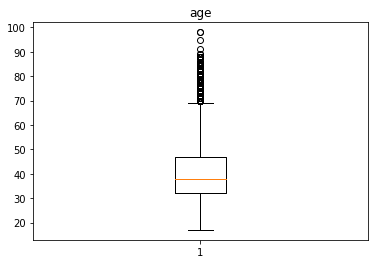

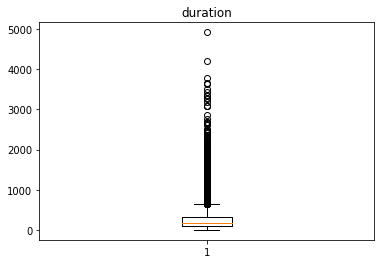

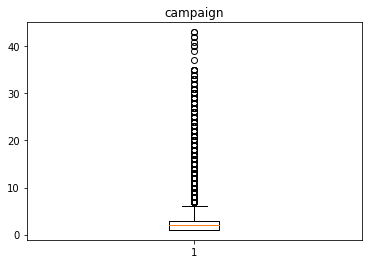

In [67]:
# Boxplots for Age, durationa nd campaign

for column in ['age','duration','campaign']:

    plt.boxplot(bank_data[column])
    plt.title(column)
    plt.show()

# From the boxplots it can be seen that the age, duration and campaign columns contain outliers

In [68]:
def outlier_percentage(data):
    return sum(data > np.percentile(data,75) + (1.5*(np.percentile(data,75))-  np.percentile(data,25)))/len(data)

In [69]:
for column in ['age','duration','campaign']:
    print('The outlier percentage of ' + column + ' ' + str(outlier_percentage(bank_data[column])))

The outlier percentage of age 0.0009252298617937894
The outlier percentage of duration 0.06025559474932053
The outlier percentage of campaign 0.06222170820563234


# As the percentage of outliers in these columns are very small, there is not a necessary need to treat the outliers of these columns.

In [70]:
# Removing 'euribor3m','nr.employed' columns

bank_data = bank_data.drop(['euribor3m','nr.employed'], axis = 1)

In [71]:

# Removing duration column as this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.

bank_data = bank_data.drop('duration', axis =1)

# Checking the relationship of numeric columns with the target variables using one way anova to find if there is significant difference in the mean between yes and no category in the outcome for each numerical column.

# ANOVA  is used to analyze the differences among group means in a sample. 
# Hypothesis:
# Null hypothesis: There is no significant difference in the mean of two groups.
# Alternate hypothesis: There is no significant difference in the mean of two groups.

In [72]:
numeric_columns_1 = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx']

In [73]:
for column in numeric_columns_1:

    a1 = bank_data[bank_data['y'] =='yes'][column].sample(n=100).values
    b1 = bank_data[bank_data['y'] =='no'][column].sample(n=100).values
    p_val = scipy.stats.f_oneway(a1,b1)[1]
    print('p-value for ' +column +' column for 100 random samples in yes and no outcme category is ' + str(p_val))

p-value for age column for 100 random samples in yes and no outcme category is 0.26511399014653186
p-value for campaign column for 100 random samples in yes and no outcme category is 0.07228515878869837
p-value for pdays column for 100 random samples in yes and no outcme category is 1.1771919338006029e-07
p-value for previous column for 100 random samples in yes and no outcme category is 0.00045089446538456066
p-value for emp.var.rate column for 100 random samples in yes and no outcme category is 4.530319477514242e-11
p-value for cons.price.idx column for 100 random samples in yes and no outcme category is 4.2668221207502963e-05
p-value for cons.conf.idx column for 100 random samples in yes and no outcme category is 0.08537847292826642


# From the ANOVA test, it can be seen that there is a significnat difference in the mean of two groups in the 'pdays','previous','emp.var.rate' and 'cons.price.idx'. So, these columns can have an influence on the outcome variable than the other columns.



# 4. Fitting classification models...

In [74]:
#Substituting the string predictor variable values with numbers
bank_data.y.replace(['yes'], 1, inplace=True)
bank_data.y.replace(['no'], 0, inplace=True)


In [75]:
# One hot encoding the categorical columns
final_df = pd.get_dummies(bank_data, drop_first=True)
final_df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,y,job_pink-collar,job_unemployed/self-employed,...,housing_yes,loan_yes,month_summer,month_winter,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,0,1,0,...,0,0,1,0,1,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,0,1,0,...,1,0,1,0,1,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,0,1,0,...,0,1,1,0,1,0,0,0,1,0


In [ ]:
final_df.columns

# The dataset is highly imbalanced with ~10% of samples in the 'yes' class. So, sampling techniques have to be followed to make the class balanced else, predictions will be biased towards the majority class. Since Logistic Regression is the simplest known classification model, fitting both L1 and L2 regularized logreg models and using Gridserach to tune for hypeparameters such as C(Inverse reguarization parameter) to use the best strength for the L1 and L2 regularization models and fit_intercept to check if the presence or absence of the intercept provides better model performance in combination with the C parameters and checking for the accuracy of the models. Also, class_weight parameter has been set to balanced to give more weights to the minorty class and less weights to majority class.

In [76]:
#Splitting the target variable and the dependent variable
X = final_df.drop('y', axis=1)
y = final_df.y
#Setting up pipelines with a StandardScaler function to normalize the numeric variable
pipelines_1 = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l1' , random_state=0, class_weight='balanced')),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=0, class_weight='balanced'))}



# Hyperparameters  for L1 model
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
    'logisticregression__fit_intercept' : [True, False]
}

# Hyperparameters for L2 model
l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
    'logisticregression__fit_intercept' : [True, False]
}


hyperparameters_1 = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters
}

#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


fitted_logreg_models = {}

# Looping through model pipelines and tuning each with GridSearchCV 
for name, pipeline in pipelines_1.items():
   
    model = GridSearchCV(pipeline, hyperparameters_1[name], n_jobs=-1)
    
    #Fitting the model on X_train, y_train
    model.fit(X_train, y_train)
    
    #Storing the model in fitted_logreg_models[name] 
    fitted_logreg_models[name] = model
    
for name, model in fitted_logreg_models.items():
    print(name, model.best_score_ )
    
   

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Fut

l1 0.790665014456836
l2 0.790665014456836


# Training accuracy
# L1 = 79%
# L2 = 79%

In [77]:
predicted_logreg_models = {}
#Overall test accuracy
for name, model in fitted_logreg_models.items():
    y_pred = model.predict(X_test)
    predicted_logreg_models[name] = accuracy_score(y_test, y_pred)
print(predicted_logreg_models)

{'l1': 0.788550501156515, 'l2': 0.788550501156515}


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


# Test accuracy
# L1 = 78%
# L2 = 78%

# Since the overall accuracy is high, checking just the accuracy will be misleading as the dataset is highly imbalanced and the model will  perform well on predicting the majority and poor on predictiong the minority class.

# So checking for the other metrics such as percision, recall and f1-score...

# L1 confusion matrix, classification report and ROC curve

In [78]:
# Confusion matrix
pd.crosstab(y_test, fitted_logreg_models['l1'].predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,7429,1821,9250
1,373,753,1126
All,7802,2574,10376


In [79]:
# Classification report
print(classification_report(y_test, fitted_logreg_models['l1'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      9250
           1       0.29      0.67      0.41      1126

   micro avg       0.79      0.79      0.79     10376
   macro avg       0.62      0.74      0.64     10376
weighted avg       0.88      0.79      0.82     10376



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


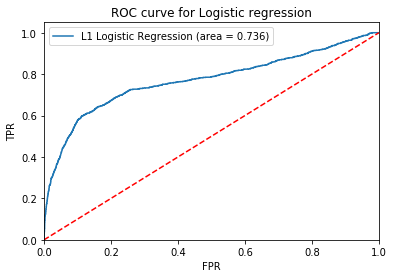

In [80]:
#ROC curve
roc_auc = roc_auc_score(y_test, fitted_logreg_models['l1'].predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, fitted_logreg_models['l1'].predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='L1 Logistic Regression (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic regression')
plt.legend(loc="upper left")
plt.show()

# L2 confusion matrix, classification report and ROC curve

In [81]:
# Confusion matrix
pd.crosstab(y_test, fitted_logreg_models['l2'].predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,7429,1821,9250
1,373,753,1126
All,7802,2574,10376


In [82]:
# Classification report
print(classification_report(y_test, fitted_logreg_models['l2'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      9250
           1       0.29      0.67      0.41      1126

   micro avg       0.79      0.79      0.79     10376
   macro avg       0.62      0.74      0.64     10376
weighted avg       0.88      0.79      0.82     10376



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


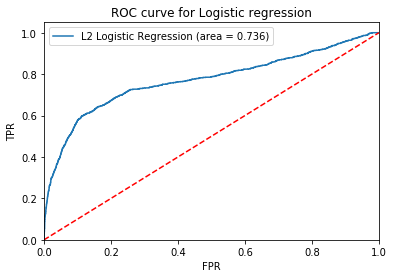

In [83]:
#ROC curve
roc_auc = roc_auc_score(y_test, fitted_logreg_models['l2'].predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, fitted_logreg_models['l2'].predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='L2 Logistic Regression (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Logistic regression')
plt.legend(loc="upper left")
plt.show()

# Both the Logistic Regression's  precision and recall for class 0 is pretty high, but for class 1 it’s low. It is able to predict the class 1 only 29% of the times among all the actual class 1 and among all the predicted class 1 it is right only 67% of the time.

# The area under the curve is ~0.74, which is substantially higher than the probability area for random guessing (0.5). Given the results of the classification report above, it could be assumed that the biggest contribution to the area under the ROC curve comes from the correctly identified class 0.

In [84]:
#pd.DataFrame({'Features':X.columns.values,'Coeff':fitted_logreg_models['l1'].best_estimator_.steps[1][1].coef_[0]})

In [85]:


# Setting up pipelines with a StandardScaler function to normalize the variables
pipelines_2 = {
    'rf' : make_pipeline(StandardScaler(), 
                         RandomForestClassifier(random_state=0, class_weight='balanced')),
    'gb' : make_pipeline(StandardScaler(), 
                         GradientBoostingClassifier(random_state=0))
}
# Hyperparameters for the Random Forest
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [50,100, 200,400],
    
}
# Hyperparameters for the Gradient Boost
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [50,100, 200,400],
    'gradientboostingclassifier__learning_rate': [0.0001,0.001,0.01, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

hyperparameters_2 = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

fitted_alternative_models = {}
# Looping through model pipelines and tuning each with GridSearchCV 
for name, pipeline in pipelines_2.items():
    
    alt_model = GridSearchCV(pipeline, hyperparameters_2[name], n_jobs=-1)
    
    #Fitting the model on X_train, y_train
    alt_model.fit(X_train, y_train)
    
    #Storing the model in fitted_logreg_models[name] 
    fitted_alternative_models[name] = alt_model
    
for name, model in fitted_alternative_models.items():
    print(name, model.best_score_ )
    
   

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value w

rf 0.8848822800495663
gb 0.9019000413052458


# Training Accuracy
# Random Forest = 88%
# Gradient Boosting = 90%

In [86]:

predicted_alternative_models = {}
# Overall test accuracy
for name, model in fitted_alternative_models.items():
    y_pred = model.predict(X_test)
    predicted_alternative_models[name] = accuracy_score(y_test, y_pred)
print(predicted_alternative_models)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


{'rf': 0.8845412490362374, 'gb': 0.9049730146491904}


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


# Test Accuracy 
# Random Forest =88%
# Gradient Boosting = 90%

# Random Forest confusion matrix, classification report and ROC Curve

In [87]:
# Confusion matrix
pd.crosstab(y_test, fitted_alternative_models['rf'].predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,8845,405,9250
1,793,333,1126
All,9638,738,10376


In [88]:
# Classification report
print(classification_report(y_test, fitted_alternative_models['rf'].predict(X_test)))

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9250
           1       0.45      0.30      0.36      1126

   micro avg       0.88      0.88      0.88     10376
   macro avg       0.68      0.63      0.65     10376
weighted avg       0.87      0.88      0.87     10376



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


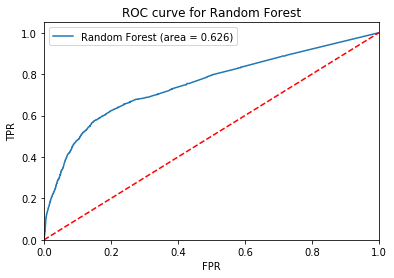

In [89]:
#ROC curve
roc_auc = roc_auc_score(y_test, fitted_alternative_models['rf'].predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, fitted_alternative_models['rf'].predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Random Forest (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random Forest')
plt.legend(loc="upper left")
plt.show()

# It can be seen that for class 0 precision is 92% and recall is 96% which is pretty high, but for class 1 precision is 45% which is better than Logistic Regression and recall is 30% which has gone worse.

# Gradient Boosting confusion matrix, classification report and ROC Curve

In [90]:
# Confusion matrix
pd.crosstab(y_test, fitted_alternative_models['gb'].predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,9134,116,9250
1,870,256,1126
All,10004,372,10376


In [91]:
# Classification report
print(classification_report(y_test, fitted_alternative_models['gb'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9250
           1       0.69      0.23      0.34      1126

   micro avg       0.90      0.90      0.90     10376
   macro avg       0.80      0.61      0.65     10376
weighted avg       0.89      0.90      0.88     10376



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


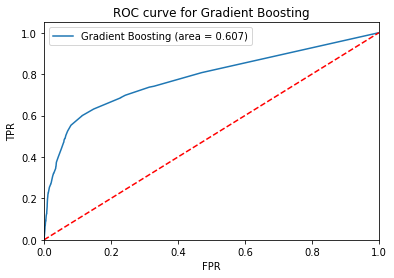

In [92]:
#ROC curve
roc_auc = roc_auc_score(y_test, fitted_alternative_models['gb'].predict(X_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_test, fitted_alternative_models['gb'].predict_proba(X_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Gradient Boosting')
plt.legend(loc="upper left")
plt.show()

# It can be seen that for class 0 precision is 91% and recall is 99% which is pretty high, but for class 1 precision is 69% which is better than Logistic Regression and Random Forest and recall is 23% which has gone still worse.

# 5. Performing different sampling techniques

In [93]:
len(final_df[final_df.y==1])

3798

In [94]:
# Separating the imbalanced observations into 2 separate datasets
df_majority = final_df[final_df.y==0]
df_minority = final_df[final_df.y==1]

# Upsampling the minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=30788, random_state=0)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

#New class counts
df_upsampled.y.value_counts()

1    30788
0    30788
Name: y, dtype: int64

# The upsampled df now has 30788 records in both the classes

In [95]:
X_upsampled = df_upsampled.drop('y', axis=1)
y_upsampled = df_upsampled.y

#Splitting the data into train and test sets
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X_upsampled, y_upsampled, test_size=0.3, random_state=0)

fitted_alternative_models_upsample = {}
# Looping through model pipelines and tuning each with GridSearchCV 
for name, pipeline in pipelines_2.items():
    
    alt_model_1 = GridSearchCV(pipeline, hyperparameters_2[name], n_jobs=-1)
    
    #Fitting the model on X_train, y_train
    alt_model_1.fit(X_up_train, y_up_train)
    
    #Storing the model in fitted_logreg_models[name] 
    fitted_alternative_models_upsample[name] = alt_model_1
    
for name, model in fitted_alternative_models_upsample.items():
    print(name, model.best_score_ )

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value w

rf 0.9280096513003735
gb 0.8176925040020416


# Training Accuracy
# Random Forest = 93%
# Gradient Boosting = 82%

In [96]:
predicted_alternative_models_upsample = {}
# Overall test accuracy
for name, model in fitted_alternative_models_upsample.items():
    y_up_pred = model.predict(X_up_test)
    predicted_alternative_models_upsample[name] = accuracy_score(y_up_test, y_up_pred)
print(predicted_alternative_models_upsample)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


{'rf': 0.9458669409408326, 'gb': 0.8187625182699074}


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


# Test Accuracy
# Random Forest = 95%
# Gradient Boosting =82%

# Random Forest confusion matrix, classification report and ROC Curve

In [97]:
# Confusion matrix
pd.crosstab(y_up_test, fitted_alternative_models_upsample['rf'].predict(X_up_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,8195,970,9165
1,30,9278,9308
All,8225,10248,18473


In [113]:
# Classification report
print(classification_report(y_up_test, fitted_alternative_models_upsample['rf'].predict(X_up_test)))

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       1.00      0.89      0.94      9165
           1       0.91      1.00      0.95      9308

   micro avg       0.95      0.95      0.95     18473
   macro avg       0.95      0.95      0.95     18473
weighted avg       0.95      0.95      0.95     18473



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


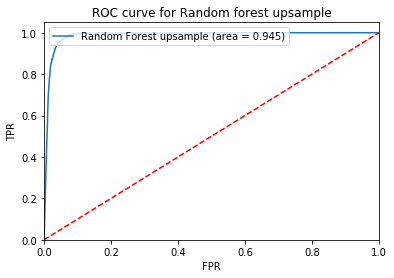

In [99]:
#ROC curve
roc_auc = roc_auc_score(y_up_test, fitted_alternative_models_upsample['rf'].predict(X_up_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_up_test, fitted_alternative_models_upsample['rf'].predict_proba(X_up_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Random Forest upsample (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random forest upsample')
plt.legend(loc="upper left")
plt.show()

In [100]:
(8195+9278)/18473

0.9458669409408326

# It can be seen that for class 0 precision is 99% and recall is 89% which is pretty high, and for class 1 precision is 91% and recall is 99% which is way better than logistic regression, random forest and gradient boosting applied without upsampling.It can also be seen that F1 score for class 0 has gone up to 0.94 and for class 1 has gone up to 0.95 which is a huge increase.

# Gradient Boosting confusion matrix, classification report and ROC Curve

In [101]:
# Confusion matrix
pd.crosstab(y_up_test, fitted_alternative_models_upsample['gb'].predict(X_up_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,7883,1282,9165
1,2066,7242,9308
All,9949,8524,18473


In [102]:
# Classification report
print(classification_report(y_up_test, fitted_alternative_models_upsample['gb'].predict(X_up_test)))

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.79      0.86      0.82      9165
           1       0.85      0.78      0.81      9308

   micro avg       0.82      0.82      0.82     18473
   macro avg       0.82      0.82      0.82     18473
weighted avg       0.82      0.82      0.82     18473



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


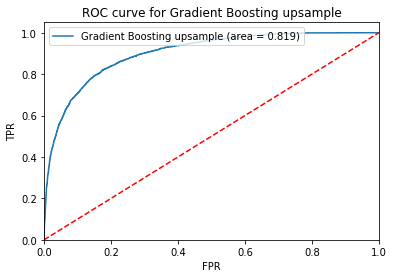

In [103]:
#ROC curve
roc_auc = roc_auc_score(y_up_test, fitted_alternative_models_upsample['gb'].predict(X_up_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_up_test, fitted_alternative_models_upsample['gb'].predict_proba(X_up_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Gradient Boosting upsample (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Gradient Boosting upsample')
plt.legend(loc="upper left")
plt.show()

# It can be seen that for class 0 precision is 79% and recall is 86% which is low compared to Random Forest for upsampled data, and for class 1 precision is 85% and recall is 78% which is way better than logistic regression, random forest and gradient boosting applied without upsampling, but lower than Random Forest on upsampled data.It can also be seen that F1 score for class 0 has down to 0.82 and for class 1 has gone down to 0.81 which is a bit lower than the Random Forest on upsampled data.

In [104]:
# Separating the imbalanced observations into 2 separate datasets
df_majority = final_df[final_df.y==0]
df_minority = final_df[final_df.y==1]

# Upsampling the minority class
df_majority_downsampled = resample(df_majority, replace=True, n_samples=3798, random_state=0)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

#New class counts
df_downsampled.y.value_counts()

1    3798
0    3798
Name: y, dtype: int64

# The downsampled data frame has 3798 records in both the classes

In [105]:
X_downsampled = df_downsampled.drop('y', axis=1)
y_downsampled = df_downsampled.y

#Splitting the data into train and test sets
X_down_train, X_down_test, y_down_train, y_down_test = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=0)

fitted_alternative_models_downsample = {}
# Looping through model pipelines and tuning each with GridSearchCV 
for name, pipeline in pipelines_2.items():
    
    alt_model_2 = GridSearchCV(pipeline, hyperparameters_2[name], n_jobs=-1)
    
    #Fitting the model on X_train, y_train
    alt_model_2.fit(X_down_train, y_down_train)
    
    #Storing the model in fitted_logreg_models[name] 
    fitted_alternative_models_downsample[name] = alt_model_2
    
for name, model in fitted_alternative_models_downsample.items():
    print(name, model.best_score_ )

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value w

rf 0.7186383298852737
gb 0.7413955237916118


# Training Accuracy
# Random Forest = 72%
# Gradient Boosting =74%

In [106]:
predicted_alternative_models_downsample = {}
# Overall test accuracy
for name, model in fitted_alternative_models_downsample.items():
    y_down_pred = model.predict(X_down_test)
    predicted_alternative_models_downsample[name] = accuracy_score(y_down_test, y_down_pred)
print(predicted_alternative_models_downsample)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


{'rf': 0.7196138657305836, 'gb': 0.7424308907415533}


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


# Test Accuracy 
# Random Forest = 72%
# Gradient Boosting =74%

# Random Forest confusion matrix, classification report and ROC Curve

In [107]:
# Confusion matrix
pd.crosstab(y_down_test, fitted_alternative_models_downsample['rf'].predict(X_down_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,886,270,1156
1,369,754,1123
All,1255,1024,2279


In [108]:
# Classification report
print(classification_report(y_down_test, fitted_alternative_models_downsample['rf'].predict(X_down_test)))

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

           0       0.71      0.77      0.73      1156
           1       0.74      0.67      0.70      1123

   micro avg       0.72      0.72      0.72      2279
   macro avg       0.72      0.72      0.72      2279
weighted avg       0.72      0.72      0.72      2279



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


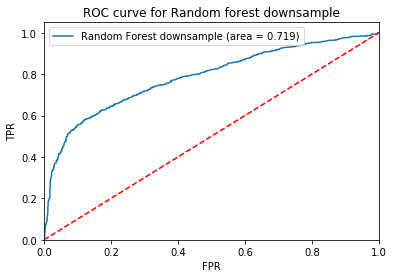

In [109]:
#ROC curve
roc_auc = roc_auc_score(y_down_test, fitted_alternative_models_downsample['rf'].predict(X_down_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_down_test, fitted_alternative_models_downsample['rf'].predict_proba(X_down_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Random Forest downsample (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random forest downsample')
plt.legend(loc="upper left")
plt.show()

# It can be observed that the precision, recall and f1-score for both the classes has come down in the downsampled dataset compared to the Random Forest on upsampled data, but it is still better than the models applied on data without any sampling

# Gradient Boosting confusion matrix, classification report and ROC Curve

In [110]:
# Confusion matrix
pd.crosstab(y_down_test, fitted_alternative_models_downsample['gb'].predict(X_down_test), rownames=['True'], colnames=['Predicted'], margins=True)

/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Predicted,0,1,All
True,,,
0,998,158,1156
1,429,694,1123
All,1427,852,2279


In [111]:
# Classification report
print(classification_report(y_down_test, fitted_alternative_models_downsample['gb'].predict(X_down_test)))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1156
           1       0.81      0.62      0.70      1123

   micro avg       0.74      0.74      0.74      2279
   macro avg       0.76      0.74      0.74      2279
weighted avg       0.76      0.74      0.74      2279



/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Ashwin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


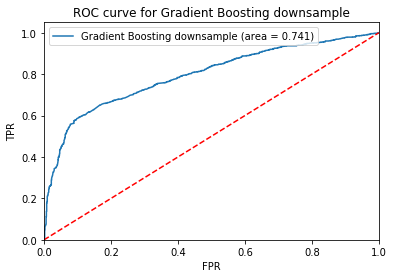

In [112]:
#ROC curve
roc_auc = roc_auc_score(y_down_test, fitted_alternative_models_downsample['gb'].predict(X_down_test))
#Obtaining false and true positives & thresholds
fpr, tpr, thresholds = roc_curve(y_down_test, fitted_alternative_models_downsample['gb'].predict_proba(X_down_test)[:,1])
#Plotting the curve
plt.plot(fpr, tpr, label='Gradient Boosting downsample (area = %0.03f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Gradient Boosting downsample')
plt.legend(loc="upper left")
plt.show()

# It can be observed that the precision, recall and f1-score for both the classes has come down in the downsampled dataset compared to the Gradient Boosting on upsampled data, but it is still better than the models applied on data without any sampling and Random Forest on downsampled data.

# Conclusion

# Among all the models Random Forest on upsampled data had the best precision and recall for both the classes.

#               precision     recall   f1-score    support

#           0       1.00           0.89      0.94          9165
#           1       0.91           1.00      0.95          9308


